In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from matplotlib import pyplot

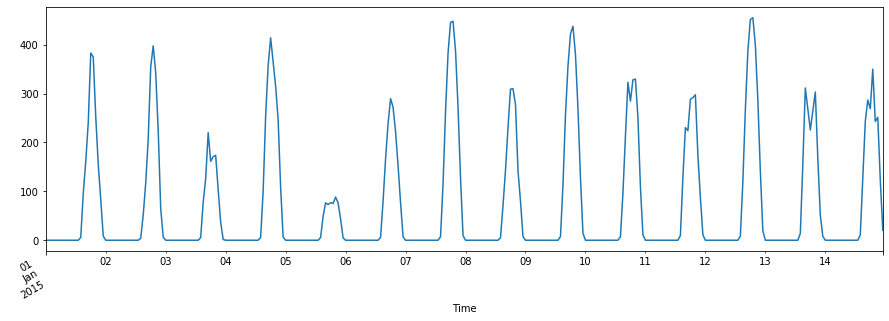

In [2]:
dat = pd.read_csv("C:/Users/fatjo876/Documents/Year_2/PhD Courses/AdvancedSolarIrradianceTheory-master/sxf_2015-2016.txt", delimiter = "\t",
                 header='infer')
dat['Time'] = pd.to_datetime(dat['Time']) # Make sure that pandas recognizes this as datetime
dat = dat.set_index('Time') # Set time column as the index (easier for plotting)
dat.head()

# line plot
dat['dw_solar'][0:336].plot(figsize=(15, 5), subplots=True)
pyplot.show()

In [3]:
dat.head()

,zen,dw_solar,G_pers,Ics,G_psm,G_nam
Time,,,,,,
2015-01-01 00:00:00,102.309,0.0,0.0,0.0,0,NaN
2015-01-01 01:00:00,111.005,0.0,0.0,0.0,0,NaN
2015-01-01 02:00:00,121.721,0.0,0.0,0.0,0,NaN
2015-01-01 03:00:00,132.508,0.0,0.0,0.0,0,NaN
2015-01-01 04:00:00,142.935,0.0,0.0,0.0,0,NaN


Test RMSE: 149.048
Test MAE: 67.599
Test R2: 0.706


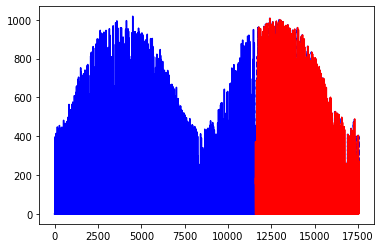

In [196]:
# persistence forecasting:

## input series
series = pd.DataFrame(dat['dw_solar'])
forecast_horizon = 24

## prepare data
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(forecast_horizon), values], axis=1)

## split into train and test
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

## persistence model
def model_persistence(x):
    return x

## model validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
    
rmse = np.sqrt(mean_squared_error(test_y, predictions))
mae = mean_absolute_error(test_y, predictions)
r2 = r2_score(test_y, predictions)

print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test R2: %.3f' % r2)

## plot the results
pyplot.plot(train_y,'blue')
pyplot.plot([None for i in train_y] + [x for x in test_y],'blue',linestyle ='--')
pyplot.plot([None for i in train_y] + [x for x in predictions],'red')
pyplot.show()

In [132]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

In [495]:
history = 168
horizon = 24

In [496]:
data =pd.DataFrame(dat['dw_solar'][0:8760])

In [497]:
def normaliziation (data):

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = pd.DataFrame(scaler.fit_transform(data))
    return scaled

In [498]:
data = normaliziation (data)

In [499]:
def prepare_data (data, history, horizon, dropnan=True):
    
    values = pd.DataFrame(data.values)
    

    cols= list()
    
    for i in range(history, 0, -1):
        cols.append(values.shift(i))
        
    for i in range(0, horizon):
        cols.append(values.shift(-i)) 
        
    dataframe = pd.concat(cols, axis=1)
    
    values=pd.DataFrame(np.vstack([values.columns, values]))
    
    if dropnan:
        dataframe.dropna(inplace=True)
    
    dataframe = dataframe.reset_index(drop=True)
    dataframe = pd.DataFrame(np.vstack([dataframe.columns, dataframe]))
   
    X = list()
    y = list()
    for i in range(len(dataframe)):
        X.append(dataframe.loc[i, 0:history-1])
        y.append(dataframe.loc[i, history:])

    return np.array(X),np.array(y)

In [500]:
X,y = prepare_data (data, history, horizon, dropnan=True)


In [501]:
train_size = int(len(X) * 0.66)
train_X , train_y = X[1:train_size] , y[1:train_size]
test_X, test_y = X[train_size:], y[train_size:]

In [502]:
# reshape from [samples, timesteps] into [samples, timesteps, features]

n_features = 1
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [ ]:
# design network
model = Sequential()
model.add(LSTM(10, activation='relu',return_sequences=True))
model.add(LSTM(10, activation='relu'))
model.add(Dense(horizon))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=10, validation_data=(test_X, test_y), verbose=2)


Train on 5655 samples, validate on 2914 samples
Epoch 1/50
 - 49s - loss: 0.0783 - accuracy: 0.0385 - val_loss: 0.0422 - val_accuracy: 0.0415
Epoch 2/50
 - 51s - loss: 0.0725 - accuracy: 0.0364 - val_loss: 0.0428 - val_accuracy: 0.0336
Epoch 3/50
 - 53s - loss: 0.0725 - accuracy: 0.0366 - val_loss: 0.0429 - val_accuracy: 0.0415
Epoch 4/50


In [490]:
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), test_y.shape[1]))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)



Test RMSE: 72.216


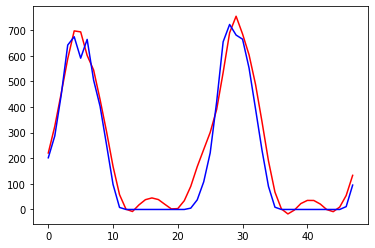

In [491]:
plt.plot(inv_yhat[0:48],'red')
plt.plot(inv_y[0:48],'blue')
plt.show()

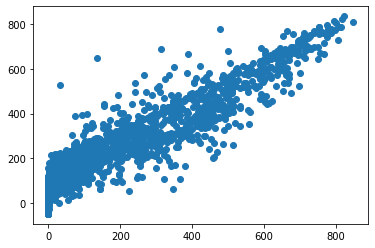

In [492]:
plt.scatter(inv_y, inv_yhat)
plt.show()

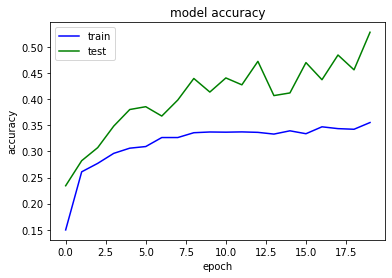

In [493]:
# summarize history for accuracy
plt.plot(history.history['accuracy'],'blue')
plt.plot(history.history['val_accuracy'],'green')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

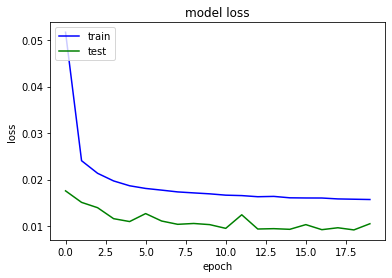

In [494]:
# summarize history for loss
plt.plot(history.history['loss'],'blue')
plt.plot(history.history['val_loss'],'green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()